# **모델 최적화**

## I. 개념 이해: “좋은 모델”의 본질

> “좋은 머신러닝 모델은 훈련 데이터만 잘 맞추는 게 아니라, **처음 보는 데이터에서도 잘 작동하는 모델**이다.”

---

### 1️⃣ 좋은 모델의 세 가지 조건

|구분|의미|예시|
|---|---|---|
|**정확성 (Accuracy)**|훈련 데이터에서 높은 성능|문제를 잘 맞추는 능력|
|**일반화 (Generalization)**|새로운 데이터에서도 높은 성능|외워서가 아니라 이해해서 푼다|
|**해석 가능성 (Explainability)**|왜 그런 결과가 나왔는지 설명 가능|단순·투명한 구조일수록 해석 용이|

> 💬 좋은 모델은 “외운 학생”이 아니라 “이해한 학생”이다.

---

### 2️⃣ 과적합 vs 일반화

|구분|설명|비유|
|---|---|---|
|**과적합(Overfitting)**|훈련 데이터에 너무 맞춤|기출문제만 외운 학생|
|**일반화(Generalization)**|패턴을 이해해 새 문제도 풂|원리를 이해한 학생|
|**과소적합(Underfitting)**|너무 단순해 학습 부족|공부를 덜 한 학생|

---

### 3️⃣ Bias–Variance Trade-Off

|구분|설명|영향|
|---|---|---|
|**Bias(편향)**|모델이 단순해서 정답과 멀리 떨어짐|underfitting|
|**Variance(분산)**|너무 복잡해서 데이터마다 요동침|overfitting|

➡ 목표: **적절한 복잡도**를 찾아 “Bias↓, Variance↓”를 동시에 달성하는 것.

---

### 4️⃣ 일반화 성능을 높이는 방법

|기법|설명|시점|
|---|---|---|
|**Dropout**|일부 뉴런을 무작위 비활성화 → 암기 방지|학습 중|
|**EarlyStopping**|검증 성능이 더 좋아지지 않으면 학습 중단|학습 도중|
|**L2 Regularization**|큰 가중치에 패널티 부여 → 복잡도 감소|모델 설계 시|

---

## 🧭 II. 개념 사고 실험

> 🎯 문제 제시
> 
> “왜 모델이 훈련 데이터에선 95%인데 실제 데이터에선 70%로 떨어질까?”

- 모델이 데이터를 “암기”했기 때문입니다.
- 즉, 훈련 손실은 계속 낮아지지만 **검증 손실(Val Loss)** 은 오히려 상승하는 순간이 옵니다.
- 이를 “**과적합 시점**”이라 부릅니다.

---

### 🔎 학습곡선으로 본 과적합 패턴

|구분|Train Loss|Val Loss|해석|
|---|---|---|---|
|정상 학습|↓|↓|함께 감소, 일반화 중|
|과적합 시작|↓|**↑ 반등**|외우기 시작|
|과소적합|높음|높음|학습 부족|

---

## 🧩 III. 사고 전환: 좋은 모델을 만드는 과정

|단계|핵심 질문|도구/방법|
|---|---|---|
|데이터 이해|“데이터 분포는 어떤가?”|EDA, 결측/불균형 처리|
|모델 선택|“단순 모델부터 시작했는가?”|Logistic → LSTM 확장|
|검증 체계|“테스트셋은 진짜 처음 보는가?”|`train_test_split`|
|과적합 방지|“언제 멈춰야 하는가?”|Dropout, EarlyStopping, L2|

> 📌 “모델 품질은 복잡도가 아니라,
> 
> **검증 데이터를 대하는 태도**에서 결정된다.”

 IV. 실습 — 과적합의 발생과 해결 체험
---

###  1. 실습 흐름

|단계|실험 주제|코드|
|---|---|---|
|STEP 1|Baseline (정규화 X) → 과적합 관찰|`model_base`|
|STEP 2|Dropout + EarlyStopping → 일반화 개선|`model_reg`|
|STEP 3|시각화 → 학습곡선 비교|`plot_history()`|
|STEP 4|혼동행렬 → 어떤 오류가 줄었는가|`ConfusionMatrixDisplay()`|


In [1]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 로드
data = pd.read_csv("nsmc_train.csv", encoding="utf-8").dropna()
X, y = data["review"], data["rating"]

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 토큰화 및 패딩
tok = Tokenizer(num_words=30000, oov_token="<OOV>")
tok.fit_on_texts(X_train)
X_train_seq = pad_sequences(tok.texts_to_sequences(X_train), maxlen=40, padding="post")
X_test_seq  = pad_sequences(tok.texts_to_sequences(X_test),  maxlen=40, padding="post")


In [2]:
model_base = Sequential([
    Embedding(30000, 64, input_length=40),
    LSTM(128),                     # 큰 모델 → 과적합 유도
    Dense(1, activation='sigmoid')
])

model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_base = model_base.fit(
    X_train_seq, y_train,
    epochs=8, batch_size=256,
    validation_split=0.2, verbose=1
)


Epoch 1/8


c:\Users\shlim\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 72ms/step - accuracy: 0.7268 - loss: 0.5041 - val_accuracy: 0.8078 - val_loss: 0.4124
Epoch 2/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.8396 - loss: 0.3477 - val_accuracy: 0.8057 - val_loss: 0.4131
Epoch 3/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.8636 - loss: 0.2997 - val_accuracy: 0.7977 - val_loss: 0.4839
Epoch 4/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8806 - loss: 0.2569 - val_accuracy: 0.7914 - val_loss: 0.5127
Epoch 5/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 65ms/step - accuracy: 0.8937 - loss: 0.2254 - val_accuracy: 0.7828 - val_loss: 0.5120
Epoch 6/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.9006 - loss: 0.2106 - val_accuracy: 0.7577 - val_loss: 0.5319
Epoch 7/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9024 - loss: 0.2038 - val_accuracy: 0.7703 - val_loss: 0.5294
Epoch 8/8
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9072 - loss: 0.1979 - val_accuracy: 0.77

In [3]:
model_reg = Sequential([
    Embedding(30000, 64, input_length=40),
    SpatialDropout1D(0.2),
    LSTM(128, dropout=0.3),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cb = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_reg = model_reg.fit(
    X_train_seq, y_train,
    epochs=16, batch_size=256,
    validation_split=0.2,
    callbacks=[cb], verbose=1
)


Epoch 1/16
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.6034 - loss: 0.6236 - val_accuracy: 0.7808 - val_loss: 0.4528
Epoch 2/16
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8174 - loss: 0.3897 - val_accuracy: 0.8089 - val_loss: 0.3988
Epoch 3/16
375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8520 - loss: 0.3245 - val_accuracy: 0.8061 - val_loss: 0.4095
Epoch 4/16
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.8686 - loss: 0.2862 - val_accuracy: 0.8068 - val_loss: 0.4333


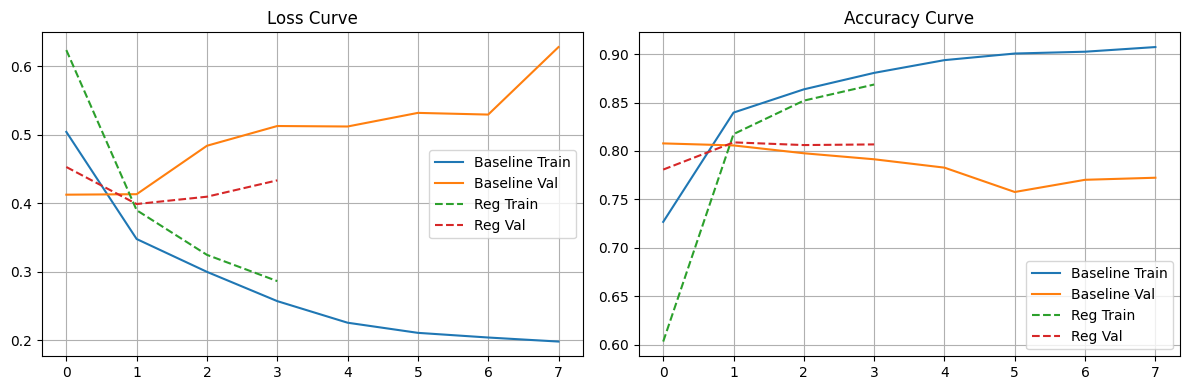

In [4]:
import matplotlib.pyplot as plt

def plot_history(h1, h2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss 비교
    axes[0].plot(h1.history['loss'], label='Baseline Train')
    axes[0].plot(h1.history['val_loss'], label='Baseline Val')
    axes[0].plot(h2.history['loss'], label='Reg Train', linestyle='--')
    axes[0].plot(h2.history['val_loss'], label='Reg Val', linestyle='--')
    axes[0].set_title('Loss Curve')
    axes[0].legend(); axes[0].grid(True)

    # Accuracy 비교
    axes[1].plot(h1.history['accuracy'], label='Baseline Train')
    axes[1].plot(h1.history['val_accuracy'], label='Baseline Val')
    axes[1].plot(h2.history['accuracy'], label='Reg Train', linestyle='--')
    axes[1].plot(h2.history['val_accuracy'], label='Reg Val', linestyle='--')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend(); axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history_base, history_reg)


Baseline 정확도: 0.7653 / Regularized 정확도: 0.8035
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


c:\Users\shlim\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shlim\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\shlim\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


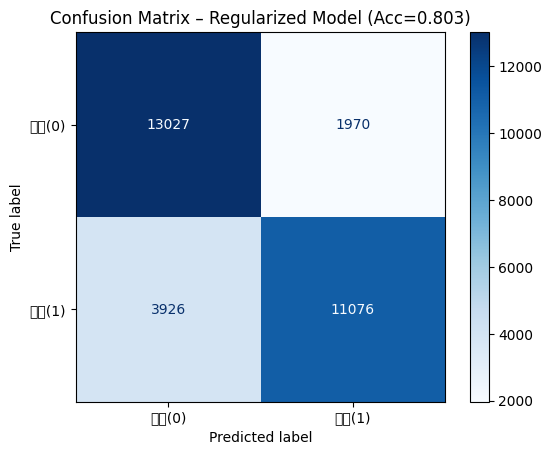

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

loss_base, acc_base = model_base.evaluate(X_test_seq, y_test, verbose=0)
loss_reg, acc_reg = model_reg.evaluate(X_test_seq, y_test, verbose=0)
print(f"Baseline 정확도: {acc_base:.4f} / Regularized 정확도: {acc_reg:.4f}")

# 예측
y_prob = model_reg.predict(X_test_seq).ravel()
y_pred = (y_prob > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["부정(0)", "긍정(1)"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix – Regularized Model (Acc={acc_reg:.3f})")
plt.show()
